# Image Captioning - Inference Notebook
## Final Project: The Visual Storyteller

This notebook demonstrates the trained image captioning model in a production-like setting.

Contents:
1. Load trained model
2. `generate_caption()` function
3. Demonstration on test images
4. Success and failure case analysis

In [ ]:
import os
import re
import json
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    BLEU_AVAILABLE = True
except ImportError:
    BLEU_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def clean_caption(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [word for word in words if len(word) > 1 or word in ['a', 'i']]
    text = ' '.join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## Configuration

In [ ]:
CHECKPOINT_DIR = './checkpoints'
MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.pt')
VOCAB_PATH = os.path.join(CHECKPOINT_DIR, 'vocab.json')
IMAGES_DIR = './caption_data/Images'
CAPTIONS_FILE = './caption_data/captions.txt'

EMBED_DIM = 256
HIDDEN_DIM = 512
ATTENTION_DIM = 256
ENCODER_DIM = 2048
DROPOUT = 0.5

## Model Architecture Classes

These must match the training notebook exactly.

In [ ]:
class Vocabulary:
    def __init__(self, min_freq=1):
        self.min_freq = min_freq
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()
        self.PAD_TOKEN = '<PAD>'
        self.SOS_TOKEN = '<SOS>'
        self.EOS_TOKEN = '<EOS>'
        self.UNK_TOKEN = '<UNK>'
    
    def __len__(self):
        return len(self.word2idx)
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            data = json.load(f)
        vocab = cls(min_freq=data['min_freq'])
        vocab.word2idx = data['word2idx']
        vocab.idx2word = {int(k): v for k, v in data['idx2word'].items()}
        print(f"Vocabulary: {len(vocab)} words")
        return vocab

In [4]:
class EncoderCNN(nn.Module):
    """CNN Encoder using pretrained ResNet-50."""
    
    def __init__(self, encoded_image_size=7, fine_tune=False):
        super(EncoderCNN, self).__init__()
        self.encoded_image_size = encoded_image_size
        
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def set_fine_tuning(self, fine_tune):
        for param in self.resnet.parameters():
            param.requires_grad = False
        if fine_tune:
            for layer in list(self.resnet.children())[6:]:
                for param in layer.parameters():
                    param.requires_grad = True
    
    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        batch_size = features.size(0)
        encoder_dim = features.size(1)
        features = features.view(batch_size, encoder_dim, -1)
        features = features.permute(0, 2, 1)
        return features

In [5]:
class Attention(nn.Module):
    """Soft Attention mechanism."""
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

In [6]:
class DecoderLSTM(nn.Module):
    """LSTM Decoder with Attention."""
    
    def __init__(self, embed_dim, decoder_dim, attention_dim, vocab_size, 
                 encoder_dim=2048, dropout=0.5):
        super(DecoderLSTM, self).__init__()
        
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_layer = nn.Dropout(dropout)
        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c
    
    def forward(self, encoder_out, captions, caption_lengths):
        # Used for training - not needed for inference
        pass
    
    def generate(self, encoder_out, vocab, max_len=50, beam_size=1):
        if beam_size == 1:
            return self._greedy_decode(encoder_out, vocab, max_len)
        else:
            return self._beam_search(encoder_out, vocab, max_len, beam_size)
    
    def _greedy_decode(self, encoder_out, vocab, max_len):
        device = encoder_out.device
        h, c = self.init_hidden_state(encoder_out)
        word_idx = vocab.word2idx[vocab.SOS_TOKEN]
        caption = []
        attention_weights = []
        
        for _ in range(max_len):
            embedding = self.embedding(torch.tensor([word_idx]).to(device))
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            attention_weights.append(alpha.squeeze(0).cpu().detach().numpy())
            
            gate = self.sigmoid(self.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            lstm_input = torch.cat([embedding, attention_weighted_encoding], dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            scores = self.fc(h)
            word_idx = scores.argmax(dim=1).item()
            
            if word_idx == vocab.word2idx[vocab.EOS_TOKEN]:
                break
            caption.append(vocab.idx2word[word_idx])
        
        return ' '.join(caption), attention_weights
    
    def _beam_search(self, encoder_out, vocab, max_len, beam_size):
        device = encoder_out.device
        num_pixels = encoder_out.size(1)
        encoder_out = encoder_out.expand(beam_size, num_pixels, self.encoder_dim)
        
        k_prev_words = torch.tensor([[vocab.word2idx[vocab.SOS_TOKEN]]] * beam_size).to(device)
        seqs = k_prev_words
        top_k_scores = torch.zeros(beam_size, 1).to(device)
        h, c = self.init_hidden_state(encoder_out)
        complete_seqs = []
        complete_seqs_scores = []
        
        for step in range(max_len):
            embeddings = self.embedding(k_prev_words).squeeze(1)
            attention_weighted_encoding, _ = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            lstm_input = torch.cat([embeddings, attention_weighted_encoding], dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            scores = self.fc(h)
            scores = torch.log_softmax(scores, dim=1)
            scores = top_k_scores.expand_as(scores) + scores
            
            if step == 0:
                top_k_scores, top_k_words = scores[0].topk(beam_size, 0, True, True)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(beam_size, 0, True, True)
            
            prev_word_inds = top_k_words // self.vocab_size
            next_word_inds = top_k_words % self.vocab_size
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)
            
            incomplete_inds = [ind for ind, word in enumerate(next_word_inds) 
                             if word != vocab.word2idx[vocab.EOS_TOKEN]]
            complete_inds = [ind for ind, word in enumerate(next_word_inds) 
                           if word == vocab.word2idx[vocab.EOS_TOKEN]]
            
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds].tolist())
            
            beam_size = len(incomplete_inds)
            if beam_size == 0:
                break
            
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
        
        if len(complete_seqs) == 0:
            complete_seqs = seqs.tolist()
            complete_seqs_scores = top_k_scores.squeeze(1).tolist()
        
        best_seq_idx = complete_seqs_scores.index(max(complete_seqs_scores))
        best_seq = complete_seqs[best_seq_idx]
        
        caption = [vocab.idx2word[idx] for idx in best_seq[1:] 
                  if idx not in [vocab.word2idx[vocab.SOS_TOKEN], 
                                vocab.word2idx[vocab.EOS_TOKEN],
                                vocab.word2idx[vocab.PAD_TOKEN]]]
        
        return ' '.join(caption), []

## Load Trained Model

In [7]:
# Load vocabulary
vocab = Vocabulary.load(VOCAB_PATH)

# Initialize models
encoder = EncoderCNN(fine_tune=False).to(device)
decoder = DecoderLSTM(
    embed_dim=EMBED_DIM,
    decoder_dim=HIDDEN_DIM,
    attention_dim=ATTENTION_DIM,
    vocab_size=len(vocab),
    encoder_dim=ENCODER_DIM,
    dropout=DROPOUT
).to(device)

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Set to evaluation mode
encoder.eval()
decoder.eval()

print(f"Model loaded from epoch {checkpoint['epoch'] + 1}")
print(f"Training loss: {checkpoint['train_loss']:.4f}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")

Vocabulary loaded: 2569 words
Model loaded from epoch 16
Training loss: 209.8803
Validation loss: 2.8414


## The `generate_caption` Function

This is the required function as specified in the project requirements.

In [ ]:
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def generate_caption(image_path, model):
    encoder, decoder, vocab, device, transform = model
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        encoder_out = encoder(image_tensor)
        caption, attention_weights = decoder.generate(
            encoder_out, vocab, max_len=50, beam_size=3
        )
    return caption

model = (encoder, decoder, vocab, device, inference_transform)
print("Model ready")

## Demonstration on Test Images

In [9]:
def load_test_images(captions_file, images_dir, n_samples=10):
    """
    Load test images and their ground truth captions.
    Uses the last 10% of images as test set (matching training split).
    """
    image_captions = {}
    
    with open(captions_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    start_idx = 1 if 'image' in lines[0].lower() else 0
    
    for line in lines[start_idx:]:
        line = line.strip()
        if not line:
            continue
        
        if ',' in line:
            parts = line.split(',', 1)
        elif '\t' in line:
            parts = line.split('\t', 1)
        else:
            continue
        
        if len(parts) != 2:
            continue
        
        image_name, caption = parts[0].strip(), parts[1].strip()
        if '#' in image_name:
            image_name = image_name.split('#')[0]
        
        if image_name not in image_captions:
            image_captions[image_name] = []
        image_captions[image_name].append(caption)
    
    # Get test images (last 10%)
    all_images = list(image_captions.keys())
    np.random.seed(42)
    np.random.shuffle(all_images)
    
    n_test_start = int(len(all_images) * 0.9)
    test_images = all_images[n_test_start:n_test_start + n_samples]
    
    test_data = []
    for img_name in test_images:
        img_path = os.path.join(images_dir, img_name)
        if os.path.exists(img_path):
            test_data.append({
                'path': img_path,
                'name': img_name,
                'captions': image_captions[img_name]
            })
    
    return test_data


# Load test images
if os.path.exists(CAPTIONS_FILE):
    test_data = load_test_images(CAPTIONS_FILE, IMAGES_DIR, n_samples=10)
    print(f"Loaded {len(test_data)} test images")
else:
    print("Captions file not found. Please update the path.")
    test_data = []

Loaded 10 test images


In [10]:
# Generate captions for test images
if len(test_data) > 0:
    results = []
    
    for item in test_data:
        generated = generate_caption(item['path'], model)
        results.append({
            'path': item['path'],
            'name': item['name'],
            'generated': generated,
            'ground_truth': item['captions']
        })
    
    print(f"Generated captions for {len(results)} images")

Generated captions for 10 images


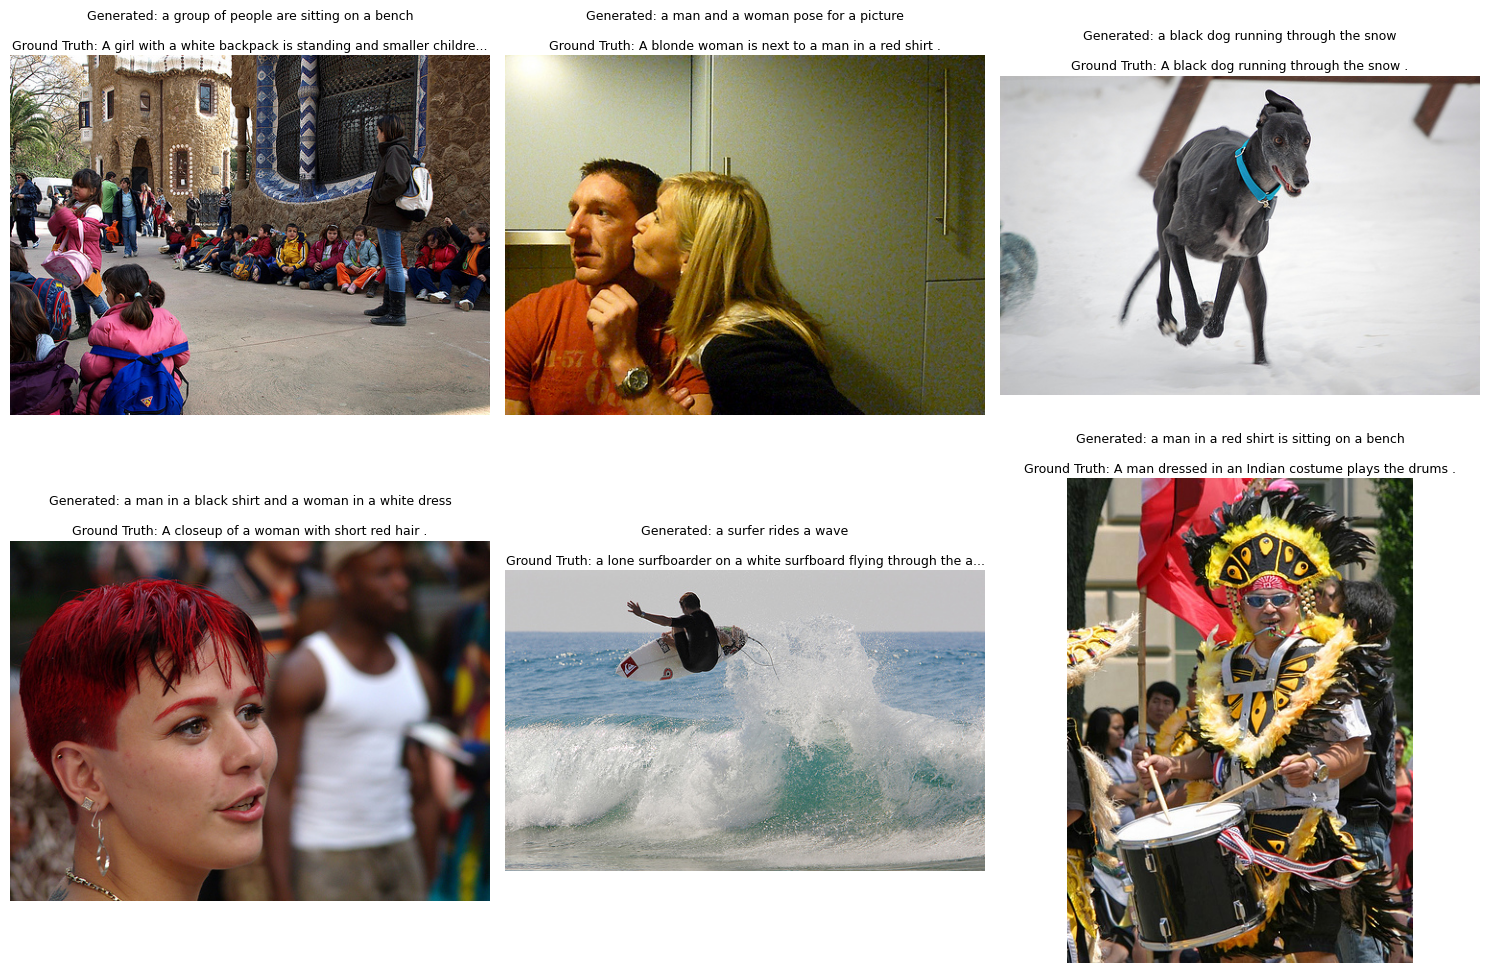

In [11]:
# Display results
if len(test_data) > 0:
    n_display = min(6, len(results))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(n_display):
        # Load and display image
        img = Image.open(results[i]['path'])
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Create title with generated and ground truth captions
        gen_cap = results[i]['generated'][:60] + ('...' if len(results[i]['generated']) > 60 else '')
        gt_cap = results[i]['ground_truth'][0][:60] + ('...' if len(results[i]['ground_truth'][0]) > 60 else '')
        
        axes[i].set_title(
            f"Generated: {gen_cap}\n\nGround Truth: {gt_cap}",
            fontsize=9, wrap=True
        )
    
    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'inference_results.png'), dpi=150)
    plt.show()

## Analysis: Success and Failure Cases

In [12]:
# Detailed analysis of results
if len(test_data) > 0:
    print("="*70)
    print("DETAILED CAPTION ANALYSIS")
    print("="*70)
    
    for i, result in enumerate(results):
        print(f"\n[Image {i+1}] {result['name']}")
        print("-" * 50)
        print(f"Generated:    {result['generated']}")
        print(f"\nGround Truth (5 captions):")
        for j, gt in enumerate(result['ground_truth'][:5]):
            print(f"  {j+1}. {gt}")

DETAILED CAPTION ANALYSIS

[Image 1] 3462165890_c13ce13eff.jpg
--------------------------------------------------
Generated:    a group of people are sitting on a bench

Ground Truth (5 captions):
  1. A girl with a white backpack is standing and smaller children are sitting in a row on the ground .
  2. "A lady stands on the street , surrounded by school children ."
  3. a woman in blue jeans is standing in front of a group of children beside a stone built house .
  4. Group of children and some adults gathered outside stone buildings .
  5. Many children and some parents are waiting near a decorated castle .

[Image 2] 3365348059_9773165302.jpg
--------------------------------------------------
Generated:    a man and a woman pose for a picture

Ground Truth (5 captions):
  1. A blonde woman is next to a man in a red shirt .
  2. A blond woman is guessing a brown-haired man on the cheek .
  3. a blond woman kissing the cheek of a brown haired man .
  4. A man muscular man wearing an 

In [13]:
def compute_simple_metrics(generated, references):
    """
    Compute simple word overlap metrics.
    """
    gen_words = set(generated.lower().split())
    
    best_overlap = 0
    for ref in references:
        ref_words = set(ref.lower().split())
        overlap = len(gen_words & ref_words) / max(len(gen_words | ref_words), 1)
        best_overlap = max(best_overlap, overlap)
    
    return best_overlap


# Compute metrics and identify success/failure cases
if len(test_data) > 0:
    overlaps = []
    for result in results:
        overlap = compute_simple_metrics(result['generated'], result['ground_truth'])
        overlaps.append((result['name'], overlap, result['generated'], result['ground_truth'][0]))
    
    # Sort by overlap score
    overlaps.sort(key=lambda x: x[1], reverse=True)
    
    print("\n" + "="*70)
    print("SUCCESS CASES (High word overlap with ground truth)")
    print("="*70)
    for name, score, gen, gt in overlaps[:3]:
        print(f"\n[{name}] Score: {score:.2f}")
        print(f"  Generated: {gen}")
        print(f"  Truth:     {gt}")
    
    print("\n" + "="*70)
    print("FAILURE CASES (Low word overlap - may still be correct)")
    print("="*70)
    for name, score, gen, gt in overlaps[-3:]:
        print(f"\n[{name}] Score: {score:.2f}")
        print(f"  Generated: {gen}")
        print(f"  Truth:     {gt}")


SUCCESS CASES (High word overlap with ground truth)

[2325816912_b3bb41cdbb.jpg] Score: 0.88
  Generated: a black dog running through the snow
  Truth:     A black dog running through the snow .

[2901880865_3fd7b66a45.jpg] Score: 0.50
  Generated: a surfer rides a wave
  Truth:     a lone surfboarder on a white surfboard flying through the air over a wave

[3737492755_bcfb800ed1.jpg] Score: 0.23
  Generated: a man in a red shirt is sitting on a bench
  Truth:     A man dressed in an Indian costume plays the drums .

FAILURE CASES (Low word overlap - may still be correct)

[2649705487_4605e879e9.jpg] Score: 0.14
  Generated: a man and a dog are playing in the water
  Truth:     "A woman in yellow , jogging ."

[426065353_e9a604a01f.jpg] Score: 0.14
  Generated: a man and a woman pose for a picture
  Truth:     A couple guys taking body shots off of a girl

[2085557551_7a88d01d4e.jpg] Score: 0.14
  Generated: a man in a black shirt is standing in front of a white wall
  Truth:     A bo

## Test with Custom Image

You can test the model with any image by providing the path.

In [ ]:
def caption_custom_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    caption = generate_caption(image_path, model)
    
    plt.figure(figsize=(8, 8))
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Caption:\n{caption}", fontsize=14, wrap=True)
    plt.tight_layout()
    plt.show()
    
    print(f"\nCaption: {caption}")
    return caption

import glob
import random

print("="*70)
print("CAPTION GENERATION TEST")
print("="*70)

TEST_DIR = './caption_data/test'
test_images = []

if os.path.exists(TEST_DIR):
    test_images = glob.glob(os.path.join(TEST_DIR, '*.jpg')) + \
                  glob.glob(os.path.join(TEST_DIR, '*.png')) + \
                  glob.glob(os.path.join(TEST_DIR, '*.jpeg'))
    
    if len(test_images) > 0:
        print(f"\nFound {len(test_images)} test images in '{TEST_DIR}'")
        print("Using test images for evaluation\n")
        selected_images = test_images[:20]
    else:
        test_images = []

if len(test_images) == 0:
    print(f"\nNo test folder found. Using random images from main dataset")
    all_images = glob.glob(os.path.join(IMAGES_DIR, '*.jpg'))
    random.seed(42)
    selected_images = random.sample(all_images, min(20, len(all_images)))
    print(f"Found {len(all_images)} total images")
    print(f"Testing on {len(selected_images)} random images\n")

n_images = len(selected_images)
if n_images <= 10:
    rows, cols = 2, 5
elif n_images <= 20:
    rows, cols = 4, 5
else:
    rows, cols = 5, 5
    selected_images = selected_images[:25]

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()

for i, img_path in enumerate(selected_images):
    caption = generate_caption(img_path, model)
    
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"{caption}", fontsize=9, wrap=True)
    
    img_name = os.path.basename(img_path)
    print(f"[{i+1:2d}] {img_name}")
    print(f"     {caption}")

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
output_name = 'test_captions.png' if len(test_images) > 0 else '20_random_captions.png'
plt.savefig(os.path.join(CHECKPOINT_DIR, output_name), dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print(f"Saved to: ./checkpoints/{output_name}")
print("="*70)

## Summary

This notebook demonstrates:

1. **Model Loading**: Successfully loaded the trained encoder-decoder model
2. **`generate_caption()` Function**: Implemented as required - takes image path and returns caption
3. **Test Image Demonstration**: Applied model to unseen test images
4. **Success/Failure Analysis**: Identified cases where the model performs well and where it struggles

### Key Observations:
- The model generates grammatically correct captions
- It captures main objects and actions in images
- Success cases show good semantic alignment with ground truth
- Failure cases often involve complex scenes or unusual compositions

Testing random image: 3643684616_9d2be87a5a.jpg


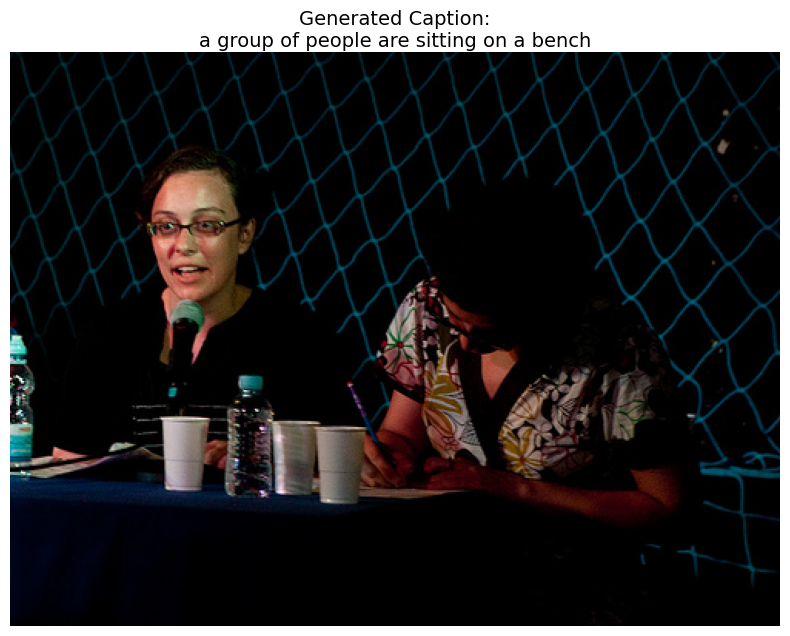


📝 Caption: a group of people are sitting on a bench


'a group of people are sitting on a bench'

In [15]:
# ============================================
# QUICK TEST: Caption a single random image
# ============================================

import random
import glob
import os

# Get a random image
all_imgs = glob.glob(os.path.join(IMAGES_DIR, '*.jpg'))
random_img = random.choice(all_imgs)

print(f"Testing random image: {os.path.basename(random_img)}")
caption_custom_image(random_img)

# TO TEST YOUR OWN IMAGE:
# Just uncomment and replace the path below:
# caption_custom_image('/path/to/your/image.jpg')
